In [1]:
import torch
from mmtrack.apis import init_model, inference_mot

from mmtrack.utils import register_all_modules
register_all_modules()

/home/hoang/miniconda3/envs/mot-mmtrack-1x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from mmcv import VideoReader
imgs = VideoReader("../demo/test1.mp4")

model = init_model(
    config="../configs/mot/qdtrack/qdtrack_faster-rcnn_r50_fpn_aic.py",
    checkpoint="../checkpoints/qdtrack_faster-rcnn_aic.pth")

03/19 15:28:57 - mmengine - WARNING - The "model" registry in mmtrack did not set import location. Fallback to call `mmtrack.utils.register_all_modules` instead.
03/19 15:28:57 - mmengine - WARNING - The "model" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
03/19 15:28:57 - mmengine - WARNING - The "task util" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
03/19 15:28:58 - mmengine - WARNING - The "weight initializer" registry in mmtrack did not set import location. Fallback to call `mmtrack.utils.register_all_modules` instead.
03/19 15:28:58 - mmengine - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
03/19 15:28:58 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://detectron2/resnet50_caffe
03/19 15:28:58 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: 

In [3]:
@torch.no_grad()
def get_feats(model, img, frame_id):
    import numpy as np
    from mmengine.dataset import Compose, default_collate
    model.to("cpu").eval()
    cfg = model.cfg
    data = dict(
        img=img.astype(np.float32), frame_id=frame_id, ori_shape=img.shape[:2])
    # remove the "LoadImageFromFile" and "LoadTrackAnnotations" in pipeline
    test_pipeline = Compose(cfg.test_dataloader.dataset.pipeline[2:])
    data = test_pipeline(data)
    data = default_collate([data])
    print(data.keys())

    img = data['inputs']['img'][:, 0]
    data_samples = data['data_samples']
    fmap = model.detector.extract_feat(img)
    proposals = model.detector.rpn_head.predict(fmap, data_samples)
    det_results = model.detector.roi_head.predict(fmap, proposals, data_samples, rescale=True)

    track_data_sample = data_samples[0]
    track_data_sample.pred_det_instances = det_results[0]

    bboxes = det_results[0].bboxes
    labels = det_results[0].labels
    scores = det_results[0].scores

    rescaled_bboxes = bboxes.clone()
    scale_factor = rescaled_bboxes.new_tensor(
        data_samples[0].metainfo['scale_factor']).repeat((1, 2))
    rescaled_bboxes = rescaled_bboxes * scale_factor
    bbox_feats = model.track_head.extract_roi_feats(fmap, [rescaled_bboxes])

    return {
        "bboxes": bboxes,
        "labels": labels,
        "scores": scores,
        "bbox_feats": bbox_feats,
    }

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def crop_image(img, bbox):
    h, w = img.shape[:2]
    x1, y1, x2, y2 = bbox
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)
    return img[y1:y2, x1:x2].copy()

def visualize(img, bboxes, bbox_feats, heatmap_weight=0.4, figsize=(20, 20)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(ncols=len(bboxes), figsize=figsize)

    bbox_feats = torch.sum(bbox_feats ** 2, dim=1)
    b, fh, fw = bbox_feats.shape
    bbox_feats = torch.nn.functional.normalize(bbox_feats.flatten(1), p=2, dim=1).view(b, fh, fw)

    for ax, bbox, bbox_feat in zip(axes, bboxes, bbox_feats):
        bbox = bbox.cpu().numpy()
        img_crop = crop_image(img, bbox.astype(np.int32).tolist())

        h, w = img_crop.shape[:2]
        hm = bbox_feat.cpu().numpy()
        print(hm)
        hm = cv2.resize(hm, (w, h), interpolation=cv2.INTER_CUBIC)

        hm = 255 * (hm - np.min(hm)) / (np.max(hm) - np.min(hm) + 1e-6)
        hm = np.floor(hm).astype(np.uint8)
        hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

        overlapped = cv2.addWeighted(img_crop, 1 - heatmap_weight, hm, heatmap_weight, 0)
        
        ax.imshow(overlapped)
        ax.set_xticks([])
        ax.set_yticks([])

dict_keys(['inputs', 'data_samples'])
[[0.07125267 0.07728001 0.09525208 0.11483733 0.10310971 0.08678237
  0.08522447]
 [0.12941231 0.12358207 0.15074979 0.17265356 0.17245102 0.15444383
  0.13859488]
 [0.15479319 0.14997455 0.16965745 0.18613538 0.19172648 0.2106788
  0.2084431 ]
 [0.13501644 0.15160239 0.15178993 0.1677046  0.16575554 0.19943894
  0.17327765]
 [0.2097262  0.1507755  0.12942076 0.13479586 0.13565972 0.17424616
  0.15701807]
 [0.11019211 0.09565736 0.09872857 0.10879208 0.11193708 0.12116209
  0.11873139]
 [0.11924201 0.11855073 0.11487389 0.11698829 0.11930162 0.11229714
  0.13615775]]
[[0.09690849 0.13664532 0.1421189  0.10401647 0.09723722 0.11296295
  0.12554364]
 [0.1334543  0.14322113 0.14057133 0.15558793 0.12826103 0.14290364
  0.12183671]
 [0.15168396 0.1567105  0.18988106 0.17554587 0.13049348 0.12791467
  0.11100754]
 [0.15664592 0.14772126 0.17502324 0.233774   0.19550636 0.16933611
  0.13566014]
 [0.15634117 0.14259082 0.12640865 0.18006046 0.17200272 0.1

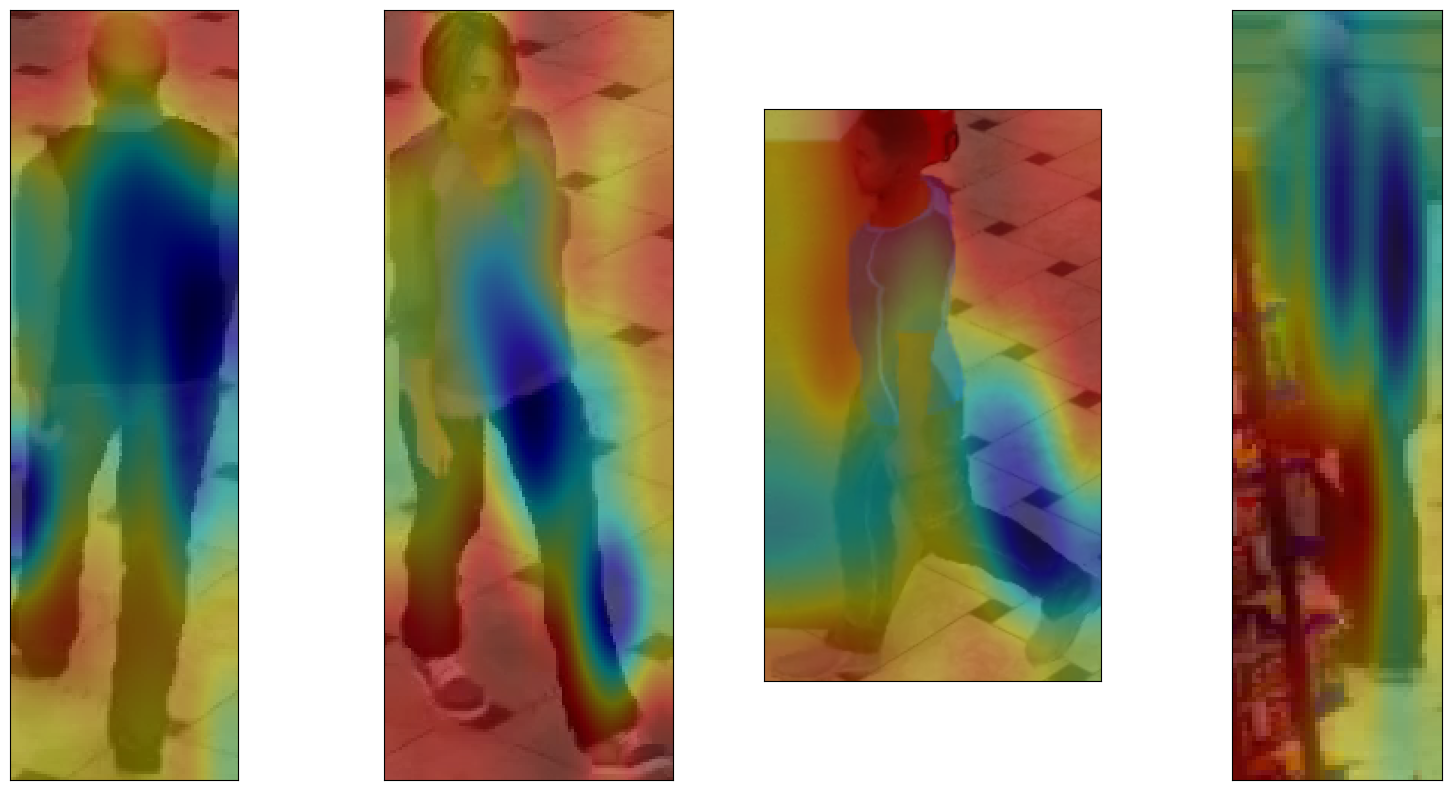

In [7]:
img_np = imgs[250]
img = torch.from_numpy(img_np).moveaxis(-1, 0)
results = get_feats(model, img_np, 0)

visualize(img_np, results["bboxes"], results["bbox_feats"], figsize=(20, 10))